https://www.kaggle.com/kmader/nuclei-overview-to-submission/notebook  
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

%load_ext autoreload
%autoreload 2
%matplotlib inline

import _init_path
from UNet import UNet
from inference import inference
from metrics import mean_iou, dice_coef_loss

from config import ClfResumeConfig
conf = ClfResumeConfig()

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(conf.gpu)

configproto = tf.ConfigProto()
configproto.gpu_options.allow_growth = True
sess = tf.Session(config=configproto)

/home/liushrui/install/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Path setup.


# Load Data

In [2]:
%%time
with np.load(conf.train_load_path) as f:
    print(f.files)
    train_images = f['images']
    train_masks = f['masks']

['masks', 'images']
CPU times: user 3.83 s, sys: 392 ms, total: 4.22 s
Wall time: 4.15 s


In [3]:
%%time
with np.load(conf.test_load_path) as f:
    print(f.files)
    test_images = f['images']
    test_image_shapes = f['shapes']

['images', 'shapes']
CPU times: user 448 ms, sys: 48 ms, total: 496 ms
Wall time: 487 ms


In [4]:
train_data = train_images / 255
train_labels = np.expand_dims(train_masks, axis=-1)

train_data.shape, train_labels.shape

((670, 256, 256, 3), (670, 256, 256, 1))

In [5]:
train_data.max(), train_data.min(), np.unique(train_labels)

(1.0, 0.0, array([0, 1]))

# Model

In [6]:
model = UNet()

In [7]:
model.compile(optimizer=conf.optimizer, loss=conf.loss, metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [ ]:
checkpointer = ModelCheckpoint(filepath=conf.weight_path, verbose=1, period=5, save_weights_only=True)
best_keeper = ModelCheckpoint(filepath=conf.best_path, verbose=1, save_weights_only=True,
                              monitor='val_mean_iou', save_best_only=True, period=1, mode='max')

csv_logger = CSVLogger(conf.csv_path)
tensorboard = TensorBoard(log_dir=conf.log_path)

early_stopping = EarlyStopping(monitor='val_mean_iou', min_delta=0, mode='max', patience=conf.val_patience, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_mean_iou', factor=conf.lr_reduce_ratio, patience=conf.lr_patience,
                               verbose=1, mode='max', epsilon=1.e-5, cooldown=conf.cooldown, min_lr=conf.min_lr)

with open(conf.yaml_path, "w") as f:
    f.write(model.to_yaml())

print("Started training @%s." % conf.now())

model.fit(train_data, train_labels, validation_split=0.1,
          batch_size=conf.steps, epochs=conf.epochs, #max_queue_size=conf.steps * 50,
          callbacks=[checkpointer, best_keeper, csv_logger, early_stopping, lr_reducer, tensorboard])

model.save_weights(conf.final_path)
print("Finished @%s." % conf.now())

Started training @2018-03-16 18:32:09.260147.
Train on 603 samples, validate on 67 samples
Epoch 1/500
603/603 [==============================] - 14s 23ms/step - loss: 0.1271 - mean_iou: 0.5348 - val_loss: 0.1185 - val_mean_iou: 0.5644

Epoch 00001: val_mean_iou improved from -inf to 0.56438, saving model to /home/liushrui/code/dsb2018/weights/UNet/180316182532/best.hdf5
Epoch 2/500
603/603 [==============================] - 13s 22ms/step - loss: 0.1129 - mean_iou: 0.5849 - val_loss: 0.1086 - val_mean_iou: 0.6048

Epoch 00002: val_mean_iou improved from 0.56438 to 0.60479, saving model to /home/liushrui/code/dsb2018/weights/UNet/180316182532/best.hdf5
Epoch 3/500
603/603 [==============================] - 13s 22ms/step - loss: 0.1070 - mean_iou: 0.6214 - val_loss: 0.1093 - val_mean_iou: 0.6350

Epoch 00003: val_mean_iou improved from 0.60479 to 0.63504, saving model to /home/liushrui/code/dsb2018/weights/UNet/180316182532/best.hdf5
Epoch 4/500
603/603 [==============================] -

In [54]:
test_image_shape = test_image_shapes
model.load_model('../weights/UNet/model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})

In [55]:
test_df = inference(model, test_image_shape)

41 images have been resized:
2560 regions found for 65 images


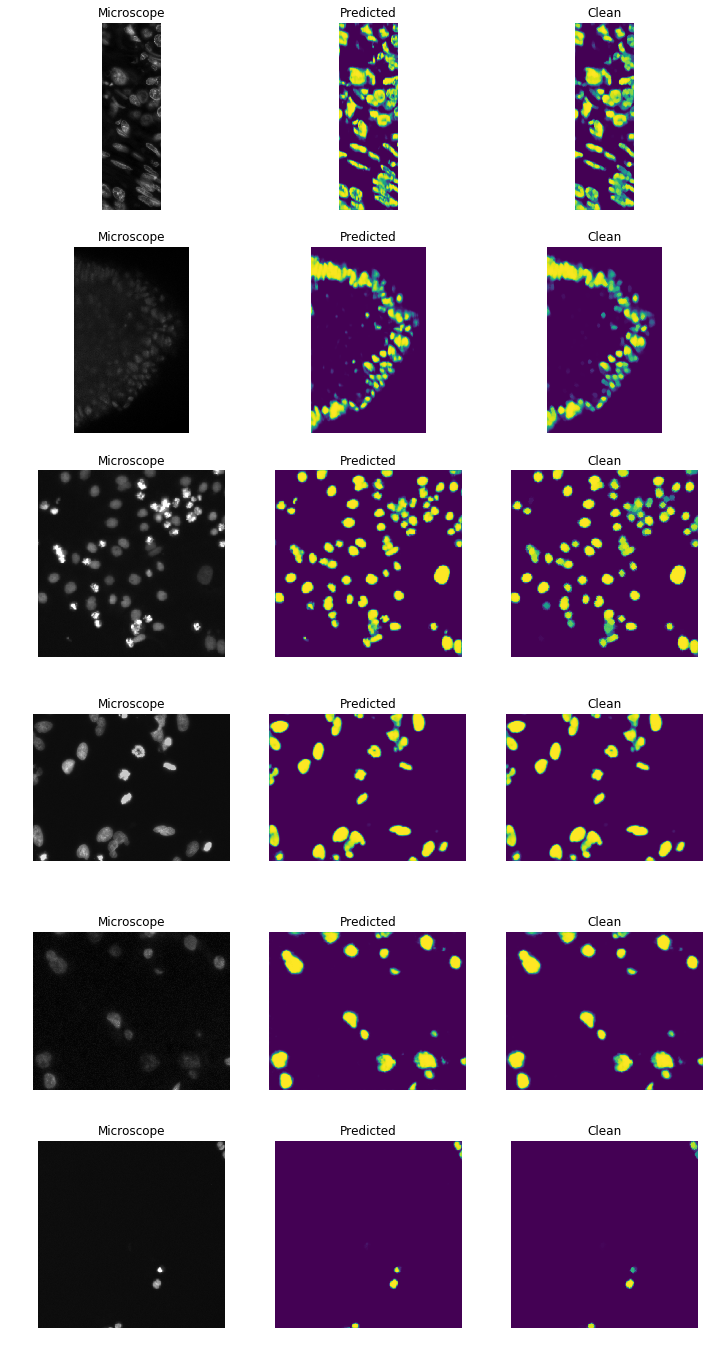

In [59]:
n_img = 6

fig, m_axs = plt.subplots(n_img, 3, figsize = (12, 24))

for (_, d_row), (c_im, c_lab, c_clean) in zip(test_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(imread(d_row['path']))
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['mask'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['mask']))
    c_clean.axis('off')
    c_clean.set_title('Clean')